In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext heat

In [8]:
# %%heat
from collections import defaultdict, Counter
import requests, json, rich, re, os, sys, unicodedata, io, hashlib, glob, collections
from IPython.display import IFrame, HTML, Image, JSON
from functools import partial
from tqdm.auto import tqdm
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()
# sys.path.insert(0, 'src')

import plotly.express as px
import pandas as pd
import numpy as np

import argilla as rg
from argilla.client.feedback.schemas.enums import ResponseStatusFilter
from argilla.client.feedback.integrations.textdescriptives import TextDescriptivesExtractor
from argilla.client.feedback.utils import create_token_highlights, audio_to_html, image_to_html, video_to_html
from argilla.client.feedback.utils import assign_records, assign_workspaces

from pdf2image import convert_from_path

import deepdoctection as dd
from unstructured.staging.argilla import stage_for_argilla
from llmsherpa.readers import LayoutPDFReader

from extralit.extraction.models.paper import PaperExtraction, SchemaStructure
from extralit.preprocessing.methods import unstructured as unstructured 
from extralit.preprocessing.methods import llmsherpa as llmsherpa
from extralit.preprocessing.methods import nougat as nougat
from extralit.preprocessing.segment import Segments, FigureSegment
from extralit.preprocessing.merge_segments import merge_extractions
from extralit.preprocessing.document import *
from extralit.convert.json_table import json_to_df, df_to_json
from extralit.convert.html_table import html_table_to_json
from extralit.convert.text import remove_markdown_from_string
from extralit.pipeline.ingest.record import get_record_data
from extralit.metrics.extraction import grits_from_pandas, grits_multi_tables

from extralit.server.context.vectordb import get_weaviate_client

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1500)
pd.set_option('max_colwidth', 100)

In [9]:
import weaviate
from extralit.extraction.vector_store import WeaviateVectorStore
from llama_index.core.vector_stores import (
    MetadataFilter,
    MetadataFilters,
    FilterOperator, ExactMatchFilter,
)

weaviate_client = get_weaviate_client()

/var/folders/yg/6jm_z4c91d30k5l7hm3s7h580000gp/T/ipykernel_75182/2468869230.py:9: ResourceWarning: unclosed <socket.socket fd=78, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.0.2', 64655), raddr=('10.24.49.73', 80)>
  weaviate_client = get_weaviate_client()


In [10]:
from llama_index.core import set_global_handler, Settings, callbacks, PromptTemplate
### comment out langfuse code 
# import langfuse
# from langfuse.llama_index import LlamaIndexCallbackHandler

# langfuse_callback_handler = LlamaIndexCallbackHandler(
#     public_key=os.environ['LANGFUSE_PUBLIC_KEY'],
#     secret_key=os.environ['LANGFUSE_SECRET_KEY'],
#     host=os.environ['LANGFUSE_HOST'],
# )
# if not Settings.callback_manager.handlers:
#     Settings.callback_manager.add_handler(langfuse_callback_handler)
# set_global_handler("langfuse")

# Ensure the global handler is NOT set to langfuse
set_global_handler("simple")

In [11]:
client = rg.init(
    api_url='http://10.24.49.60/',
    api_key="386a5806-0182-41f6-8076-f4b557818f0b",
    workspace='preprocessing',
)

In [20]:
remote_dataset = rg.FeedbackDataset.from_argilla(name="Table-Preprocessing", workspace="itn-recalibration")

users = rg.Workspace.from_name('itn-recalibration').users
users_id_to_username = {u.id: u.username for u in users}
users

[UserModel(id=6d8ee721-49b7-4d1f-bf4c-d6b0eb187c62, first_name=Jonny, last_name=Tran, full_name=Jonny Tran, username=jonnytr, role=admin, workspaces=['jonnytr', 'itn-recalibration', 'gold-standard', 'test-extraction', 'preprocessing', 'itn-recalibration-scratch'], inserted_at=2024-01-11 01:48:44.477722, updated_at=2024-03-22 06:56:39.809768),
 UserModel(id=e96c9d89-36f4-4240-a592-9734087371d3, first_name=Amelia, last_name=Bertozzi-Villa, full_name=Amelia Bertozzi-Villa, username=ameliabv, role=admin, workspaces=['ameliabv', 'itn-recalibration', 'gold-standard', 'test-extraction', 'preprocessing', 'itn-recalibration-scratch'], inserted_at=2024-01-11 01:48:44.549157, updated_at=2024-03-22 06:56:39.815293),
 UserModel(id=91b12ed4-2aff-46d6-9eb3-c15d44e00e2a, first_name=Kate, last_name=Battle, full_name=Kate Battle, username=kateb, role=admin, workspaces=['kateb', 'itn-recalibration', 'gold-standard', 'test-extraction', 'preprocessing', 'itn-recalibration-scratch'], inserted_at=2024-01-11 

# Load papers

In [13]:
papers = pd.read_parquet('config/extraction_queue_197papers_2024-04-03.parquet')
extractions = pd.read_csv('data/processed/extractions_preJonny_cleaned.csv', index_col='reference')

papers = papers.assign(collections=papers['collections'].map(', '.join))

papers.shape

(197, 32)

In [14]:
# Upload PDFs if not already exist in the Argilla database
# for ref, paper in tqdm(papers.iterrows()):
#     doc = remote_dataset.add_document(rg.Document.from_file(
#         paper.file_path, reference=ref, pmid=paper.pmid, doi=paper.doi, id=paper.get('id')))

In [19]:
papers_uploaded = {r.metadata['reference'] \
                   for r in tqdm(remote_dataset.filter_by(
                       metadata_filters=rg.TermsMetadataFilter(name='type', values=['table'])).records)}
len(papers_uploaded)

  0%|          | 0/670 [00:00<?, ?it/s]

111

# Push to Argilla

## Create dataset

In [6]:
from extralit.pipeline.export.dataset import create_preprocessing_dataset

dataset = create_preprocessing_dataset()

remote_dataset = dataset.push_to_argilla(name="Table-Preprocessing", workspace="itn-recalibration-scratch")

# Initialize the TextDescriptivesExtractor
# tde = TextDescriptivesExtractor(
#     model="en",
#     metrics=['descriptive_stats'],
#     fields=["text-1"],
#     visible_for_annotators=True,
#     show_progress=True,
# )

# pdf_reader = LayoutPDFReader("https://readers.llmsherpa.com/api/document/developer/parseDocument?renderFormat=all")

FeedbackDataset(
   fields=[TextField(name='metadata', title='Metadata:', required=True, type='text', use_markdown=True, use_table=False), TextField(name='header', title='Title:', required=True, type='text', use_markdown=True, use_table=False), TextField(name='image', title='Image:', required=False, type='text', use_markdown=True, use_table=False), TextField(name='text-1', title='Method 1:', required=False, type='text', use_markdown=True, use_table=False), TextField(name='text-2', title='Method 2:', required=False, type='text', use_markdown=True, use_table=False), TextField(name='text-3', title='Method 3:', required=False, type='text', use_markdown=True, use_table=False), TextField(name='text-4', title='Method 4:', required=False, type='text', use_markdown=True, use_table=False), TextField(name='text-5', title='Method 5:', required=False, type='text', use_markdown=True, use_table=False)]
   questions=[LabelQuestion(name='ranking', title='Which method extracted the most complete and acc

# Update dataset

## Choose papers queue

In [21]:
# papers_subset = ['Atieli2010effectgambiaeMalaria', Dabire2006personalpyrethroidsMalaria', 'Ochomo2017insecticidekenyaEmerging', 'Vatandoost2013washtestArthropod']
# papers_subset = ['Canning2023unwantedcountriesStudies', 'Tiruneh2020prevalencemetaanalysisPlos', 'Daley2018addressingintervention', 'Goodson2011changingafricaInfectious']
# papers_subset = ['ketoh2018efficacy', 'darriet2005pyrethoid', 'magesa1991trial', 'whopes2008report', 'quinones1998permethrin', 'kawada2014small', 'kawada2014preventive', 'randriamaherijaona2015do', 'kilian2011evidence',]
# papers_subset = ['mbogo1996impact', 'menze2020experimental', 'kitau2012species', 'kilian2008long', 'mnzava2001malaria', 'pmi2018senegal', 'hougard2003efficacy', 'pennetier2013efficacy',]
# papers_subset = ['whopes2007report', 'ngufor2016efficacy', 'okia2013bioefficacy', 'mosha2008comparative', 'quinones1997anopheles', 'ahoua2012status', 'sreehari2009wash', 'abdulla2005spatial', 'pmi2019nigeria', 'tan2016longitudinal',]
# papers_subset = ['pmi2019myanmar', 'wills2013physical', 'tokponnon2014impact', 'marchant2002socially', 'pinder2015efficacy', 'nevill1996insecticide', 'muller2006effects', 'terlouw2010impact', 'msuya1991trial', 'tungu2021efficacy',]
papers_subset = ['hamel2011combination', 'ter2003impact', 'moiroux2014human', 'schellenberg2001effect', 'tamari2020protective', 'yewhalaw2022experimental', 'tungu2021field', 'sanou2021insecticide', 'kouassi2020susceptibility', 'mulatier2019prior', 
                  'ngongang2022reduced', 'lorenz2020comparative', 'hien2021evidence', 'ngufor2020efficacy', 'sovi2022physical', 'adageba2022bio', 'githinji2020impact', 'grisales2021pyriproxyfen', 'tungu2021bio', 'tungu2021effectiveness',]
papers_subset = ['verma2022laboratory', 'accrombessi2021assessing', 'ngufor2022comparative', 'gleave2021piperonyl', 'diouf2022evaluation', 'syme2021which', 'meiwald2022association', 'gichuki2021bioefficacy', 'kibondo2022influence', 'zahouli2023small', 'toe2018do', 'nash2021systematic', 'accrombessi2023efficacy', 'syme2022pyrethroid', 'menze2022experimental', 'gebremariam2021evaluation', 'briet2020physical', 'ibrahim2020exploring', 'mieguim2021insights',]
'.'.join(papers_subset)

'verma2022laboratory.accrombessi2021assessing.ngufor2022comparative.gleave2021piperonyl.diouf2022evaluation.syme2021which.meiwald2022association.gichuki2021bioefficacy.kibondo2022influence.zahouli2023small.toe2018do.nash2021systematic.accrombessi2023efficacy.syme2022pyrethroid.menze2022experimental.gebremariam2021evaluation.briet2020physical.ibrahim2020exploring.mieguim2021insights'

In [22]:
papers_subset = papers.loc[papers_subset]
papers_subset.index

Index(['verma2022laboratory', 'accrombessi2021assessing', 'ngufor2022comparative', 'gleave2021piperonyl', 'diouf2022evaluation', 'syme2021which', 'meiwald2022association', 'gichuki2021bioefficacy', 'kibondo2022influence', 'zahouli2023small', 'toe2018do', 'nash2021systematic', 'accrombessi2023efficacy', 'syme2022pyrethroid', 'menze2022experimental', 'gebremariam2021evaluation', 'briet2020physical', 'ibrahim2020exploring', 'mieguim2021insights'], dtype='object', name='reference')

In [18]:
papers_subset = papers.loc[papers.index.difference(papers_uploaded)]
papers_subset.shape

(120, 32)

In [17]:
papers_subset.index.tolist()

['abdella2009does',
 'abdulla2001impact',
 'abilio2015bio',
 'accrombessi2021assessing',
 'accrombessi2023efficacy',
 'agossa2014laboratory',
 'agossa2015impact',
 'akoton2018experimental',
 'allossogbe2017who',
 'alonso1993malaria',
 'anshebo2014estimation',
 'asidi2004experimental',
 'asidi2005experimental',
 'asidi2012loss',
 'awolola2014impact',
 'badolo2012experimental',
 'bayili2017evaluation',
 'bayili2019experimental',
 'birhanu2019bio',
 'bobanga2013field',
 'bogh1998permethrin',
 'boussougou2017physical',
 'briet2020physical',
 'camara2018efficacy',
 'chandre2010field',
 'chouaibou2006efficacy',
 'corbel2010field',
 'curtis2003insecticide',
 'dalessandro1995mortality',
 'darriet2011combining',
 'diouf2022evaluation',
 'djenontin2009managing',
 'djenontin2010indoor',
 'etang2004reduced',
 'etang2007preliminary',
 'etang2013evaluation',
 'etang2016when',
 'fadel2019combination',
 'fane2012anopheles',
 'gebremariam2021evaluation',
 'gichuki2021bioefficacy',
 'gleave2021piperonyl

## Extract segments

In [24]:
# nougat_model = nougat.NougatOCR()
# nougat_model.batch_size = 1
nougat_model = None

In [25]:
outputs = defaultdict(lambda: {})
texts = defaultdict(lambda: {})
tables = defaultdict(lambda: {})
figures = defaultdict(lambda: {})

for id, paper in tqdm(papers_subset.iterrows(), total=len(papers_subset)):
    print(f'### {id}: {papers.loc[id, "file_path"]} ###', flush=True)
    
    ## Unstructured.io ##
    text_segs, table_segs, figure_segs = create_or_load_unstructured_segments(paper, load_only=True, redo=False)
    texts[id]['unstructured'] = text_segs
    tables[id]['unstructured'] = table_segs
    figures[id]['unstructured'] = figure_segs

    # llmsherpa ##
    text_segs, table_segs, _ = create_or_load_llmsherpa_segments(paper, load_only=True, redo=False)
    texts[id]['llmsherpa'] = text_segs
    tables[id]['llmsherpa'] = table_segs

    ## Nougat ##
    text_segs, table_segs, _ = create_or_load_nougat_segments(paper, nougat_model=nougat_model, load_only=True)
    texts[id]['nougat'] = text_segs
    tables[id]['nougat'] = table_segs

    ## pdffigures2 ##
    _, table_segs, figure_segs = create_or_load_pdffigures2_segments(paper, load_only=True, redo=False,
                                                                    jar_path='bin/pdffigures2.jar',)
    tables[id]['pdffigures2'] = table_segs
    figures[id]['pdffigures2'] = figure_segs

    ## deepdoctection ##
    _, table_segs, _ = create_or_load_deepdoctection_segments(paper, load_only=True, redo=False)
    tables[id]['deepdoctection'] = table_segs

len(tables)

  0%|          | 0/19 [00:00<?, ?it/s]

### verma2022laboratory: data/pdf/LLINPhaseIVV2022.pdf ###
### accrombessi2021assessing: data/pdf/Assessing_the_efficacy_of_two_dual_active_ingredients_long_lasting_insecticidal_.pdf ###
### ngufor2022comparative: data/pdf/Comparative_efficacy_of_two_pyrethroid_piperonyl_butoxide_nets_Olyset_Plus_and_.pdf ###
### gleave2021piperonyl: data/pdf/CD012776.pdf ###
### diouf2022evaluation: data/pdf/Evaluation_of_the_residual_efficacy_and_physical_durability_of_five_long_lasting.pdf ###
### syme2021which: data/pdf/pone_0245804_pdf.pdf ###
### meiwald2022association: data/pdf/jiaa699.pdf ###
### gichuki2021bioefficacy: data/pdf/Bioefficacy_and_durability_of_Olyset_Plus_a_permethrin_and_piperonyl__butoxi.pdf ###
### kibondo2022influence: data/pdf/Influence_of_testing_modality_on_bioefficacy_for_the_evaluation_of_Interceptor.pdf ###
### zahouli2023small: data/pdf/Small_scale_field_evaluation_of_PermaNet_Dual_a_long_lasting_net_coated_with.pdf ###
### toe2018do: data/pdf/Toe_et_al_2018_Medical_an

19

### Figure digitalization (experiments)

In [21]:
id = 'tan2016longitudinal'
i = -1
table = tables[id]['llmsherpa'].items[i]

print(papers.loc[id, 'file_path'])
print(table.header, table.number)
HTML(table.html)

data/pdf/tan2016longitudinal.pdf
 None


LLIN age 12 months,"(14) 77.8, 58.6–96.7†","(6) 33.3, 11.6–55.1","(20) 55.6, 39.3–71.8"
24 months,"(7) 38.9, 16.4–61.4","(6) 30.0, 9.9–50.1","(13) 34.2, 19.1–51.4"
Minimal effectiveness 12 months,"(18) 100.0, 100.0–100.0†","(14) 77.8, 58.6–97.0","(32) 88.9, 78.6–96.9"
24 months,"(11) 61.1, 38.6–83.6","(14) 70.0, 49.9–88.1","(25) 65.8, 50.7–80.9*"


In [23]:
fig = figures['tan2016longitudinal']['pdffigures2'][0]
fig

FigureSegment(header='Fig. 2 Correlation of chemical and bioassay results (95 % confidence intervals shown in shaded area)', page_number=10, number=2)


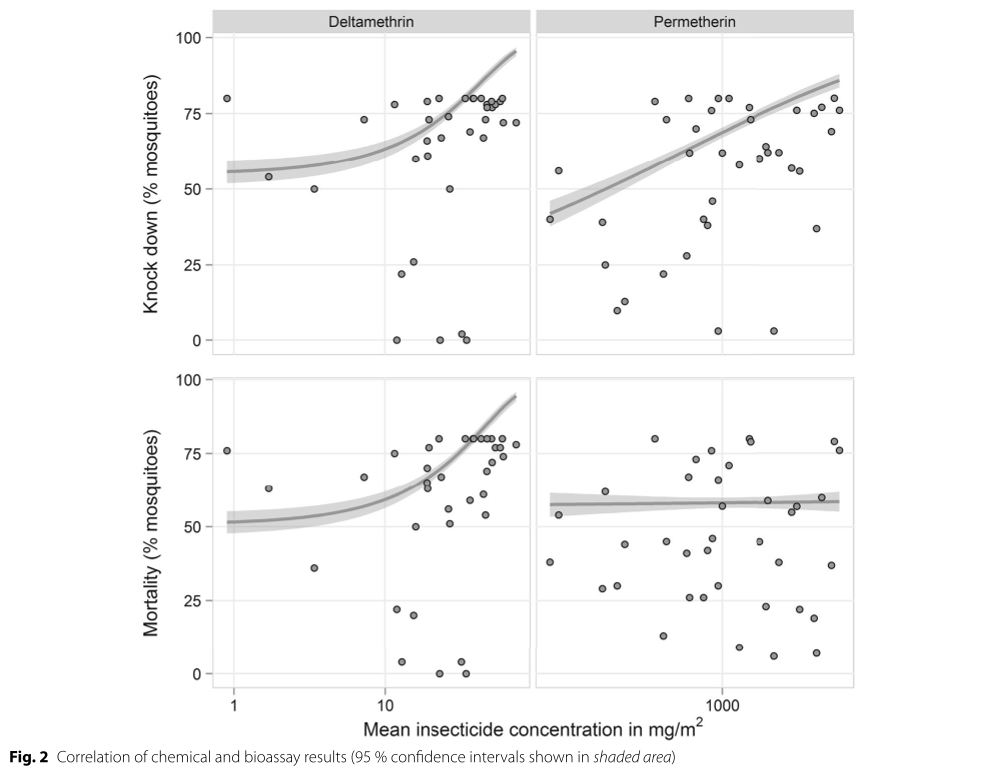

In [24]:
HTML(image_to_html(fig.image))

In [26]:
_figure_extraction_response = fig.extract_html_table()

/Users/jonnytr/micromamba/lib/python3.10/site-packages/llama_index/core/readers/file/base.py:416: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/jonnytr/Projects/ITN-recal-data-extraction/data/preprocessing/pdffigure2/tan2016longitudinal/tan2016longitudinal-Figure2-1.png'>
  docs = reader.load_data(input_file, **kwargs)
[0520 13:54.02 @segment.py:246]  INF  Extracting figure table: Fig. 2 Correlation of chemical and bioassay results (95 % confidence intervals shown in shaded area)
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(


FigureExtractionResponse(summary='The figure shows the correlation between chemical concentrations (Deltamethrin and Permethrin) and bioassay results (Knock down and Mortality) in mosquitoes. The shaded areas represent 95% confidence intervals.', html='<table>\n<thead>\n<tr>\n<th></th>\n<th>Deltamethrin</th>\n<th>Permethrin</th>\n</tr>\n</thead>\n<tbody>\n<tr>\n<td>Knock down (% mosquitoes)</td>\n<td></td>\n<td></td>\n</tr>\n<tr>\n<td>Mortality (% mosquitoes)</td>\n<td></td>\n<td></td>\n</tr>\n<tr>\n<td>Mean insecticide concentration in mg/m²</td>\n<td></td>\n<td></td>\n</tr>\n</tbody>\n</table>')

In [27]:
HTML(fig.html)

,Deltamethrin,Permethrin
Knock down (% mosquitoes),,
Mortality (% mosquitoes),,
Mean insecticide concentration in mg/m²,,


### deepdoctection (experiments)

In [ ]:
analyzer =dd.get_dd_analyzer(config_overwrite=[
    "PT.LAYOUT.WEIGHTS=microsoft/table-transformer-detection/pytorch_model.bin",   # TATR table detection model
    "PT.ITEM.WEIGHTS=microsoft/table-transformer-structure-recognition/pytorch_model.bin",  # TATR table segmentation model
    "PT.ITEM.FILTER=['table']",
    "OCR.USE_DOCTR=True",  # we disable Tesseract and use DocTr as OCR engine
    "OCR.USE_TESSERACT=False",
])

df = analyzer.analyze(path='data/pdf/Etang_et_al_2007_Trans_RSTMH.pdf')
df.reset_state()

In [ ]:
# doc = iter(df)
page = next(doc)

In [ ]:
page.annotations[1]._category_name

In [ ]:
page.annotations[0]._annotation_id

In [ ]:
table.annotation_id

In [ ]:
table = page.tables[0]
print(table.html)

In [ ]:
table.cells

In [ ]:
page.viz(ignore_default_token_class=True, interactive=True)

#### Evaluate tables extracted

In [ ]:
df = tables['Etang2007']['unstructured'][0].to_df()
df = df.dropna(axis=0, how='all').dropna(axis=1, how='all')
df

In [ ]:
# for id, paper in tqdm(papers_subset.iterrows(), total=len(papers_subset)):
#     text_segs, table_segs, _ = create_or_load_nougat_segments(paper, nougat_model=nougat_model, load_only=False, save=True)

## Create records

In [26]:
from llama_index.core import global_handler
records = []

for ref, paper in tqdm(papers_subset.iterrows()):
    doc = remote_dataset.add_document(rg.Document.from_file(
        paper.file_path, reference=ref, pmid=paper.pmid, doi=paper.doi, id=paper.get('id')))
    
    metadata = {"reference": paper.name}
    if isinstance(doc.pmid, (str, int)) and doc.pmid != 'nan':
        metadata['pmid'] = doc.pmid
    elif doc.id:
        metadata['doc_id'] = str(doc.id)

    # Table segments
    table_alignments = merge_extractions(
        deepdoctection=tables[ref]['deepdoctection'],
        unstructured=tables[ref]['unstructured'],
        llmsherpa=tables[ref]['llmsherpa'],
        nougat=tables[ref]['nougat'],
        pdffigures2=tables[ref]['pdffigures2'],
    )
    table_records = table_alignments.to_records(dataset=remote_dataset, metadata=metadata)
    records.extend(table_records)

    # Figure segments
    ### comment out langfuse code 
    # global_handler.set_trace_params(
    #     name=f"preprocess-{ref}",
    #     session_id=ref,
    #     user_id='jonnytr',
    # )
    figure_segments = merge_extractions(
        unstructured=figures[ref]['unstructured'],
        pdffigures2=figures[ref]['pdffigures2'],
    )
    for alignment in figure_segments.items:
        for source, segment in alignment.extractions.items():
            if os.path.exists(segment.image) and segment.header:
                _figure_extraction_response = segment.extract_html_table()
        
    figure_records = figure_segments.to_records(dataset=remote_dataset, metadata=metadata)
    records.extend(figure_records)

    print(paper.name, len(table_records), 'tables', len(figure_records), 'figures')

records = [r for r in records if r is not None]
len(records)

0it [00:00, ?it/s]

/Users/jonnytr/micromamba/lib/python3.10/site-packages/llama_index/core/readers/file/base.py:535: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/jonnytr/Projects/ITN-recal-data-extraction/data/preprocessing/pdffigure2/verma2022laboratory/LLINPhaseIVV2022-Figure2-1.png'>
  docs = reader.load_data(input_file, **kwargs)
[0621 00:04.51 @segment.py:251]  INF  Extracting figure table: Fig. 2 Schematic flow of work plan
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1135: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instea

verma2022laboratory 3 tables 3 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1135: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1143: PydanticDeprecatedSince20: `load_str_bytes` is deprecated. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  obj = parse.load_

accrombessi2021assessing 2 tables 1 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/llama_index/core/readers/file/base.py:535: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/jonnytr/Projects/ITN-recal-data-extraction/data/preprocessing/unstructured/ngufor2022comparative/figures/figure-6-7.jpg'>
  docs = reader.load_data(input_file, **kwargs)
[0621 00:05.23 @segment.py:251]  INF  Extracting figure table: Fig. 1 Mortality of wild pyrethroid-resistant Anopheles gambiae s.l. in experimental huts in Cove, Benin evaluating different net types. Vertical lines indicate 95% confidence interval estimates whilst bars with the same letter label are not significantly different (P > 0.05)
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jo

ngufor2022comparative 9 tables 5 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/llama_index/core/readers/file/base.py:535: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/jonnytr/Projects/ITN-recal-data-extraction/data/preprocessing/pdffigure2/gleave2021piperonyl/CD012776-Figure1-1.png'>
  docs = reader.load_data(input_file, **kwargs)
[0621 00:06.27 @segment.py:251]  INF  Extracting figure table: Figure 1.   Study flow diagram.
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1135: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instead. Deprecat

gleave2021piperonyl 133 tables 2 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/llama_index/core/readers/file/base.py:535: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/jonnytr/Projects/ITN-recal-data-extraction/data/preprocessing/unstructured/diouf2022evaluation/figures/figure-4-7.jpg'>
  docs = reader.load_data(input_file, **kwargs)
[0621 00:06.44 @segment.py:251]  INF  Extracting figure table: Fig. 1 Localities where LLINs were distributed and durability monitored
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1135: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data t

diouf2022evaluation 8 tables 5 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/llama_index/core/readers/file/base.py:535: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/jonnytr/Projects/ITN-recal-data-extraction/data/preprocessing/unstructured/syme2021which/figures/figure-9-2.jpg'>
  docs = reader.load_data(input_file, **kwargs)
[0621 00:07.41 @segment.py:251]  INF  Extracting figure table: Fig 1. Monthly mortality rates of wild, free-flying pyrethroid-resistant Anopheles gambiae sensu lato entering experimental huts with pirimiphos-methyl CS IRS applied alone and in combination with DuraNet1 in Covè, southern Benin. Mortality was cumulated over successive months. Error bars represent 95% CI.
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  w

syme2021which 5 tables 4 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/llama_index/core/readers/file/base.py:535: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/jonnytr/Projects/ITN-recal-data-extraction/data/preprocessing/unstructured/meiwald2022association/figures/figure-4-3.jpg'>
  docs = reader.load_data(input_file, **kwargs)
[0621 00:08.19 @segment.py:251]  INF  Extracting figure table: Figure 2. A, Resistance intensity of field-caught Anopheles gambiae sensu lato (s.l.) after exposure to 1, 2, 5, or 10 times the diagnostic dose of pyrethroid insecticides. Mean knockdown/acute toxicity rates after 30-minute exposure are shown with 95% confidence intervals (CIs). Knockdown or mortality rates at the same dose per insecticide sharing a letter do not differ significantly (P > .05). Mortality rates <90% (lower red line) represent confirmed resistance at the diagnostic dose (1×), and rates <98% (upper red line) indicate moderate to high-intensity resistance or high-intensity resistance

meiwald2022association 3 tables 2 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1135: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1143: PydanticDeprecatedSince20: `load_str_bytes` is deprecated. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  obj = parse.load_

gichuki2021bioefficacy 7 tables 1 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/llama_index/core/readers/file/base.py:535: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/jonnytr/Projects/ITN-recal-data-extraction/data/preprocessing/unstructured/kibondo2022influence/figures/figure-7-6.jpg'>
  docs = reader.load_data(input_file, **kwargs)
[0621 00:09.00 @segment.py:251]  INF  Extracting figure table: Fig. 2 Mosquito mortality after exposure to Interceptor® and Interceptor® G2 ITNs in Ifakara ambient chamber test (IACT), WHO tunnel test, cone and experimental hut. a An. arabiensis, b Cx. quinquefasciatus, c An. gambiae s.s., d Ae. aegypti
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site

kibondo2022influence 5 tables 4 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1135: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1143: PydanticDeprecatedSince20: `load_str_bytes` is deprecated. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  obj = parse.load_

zahouli2023small 4 tables 5 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1135: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1143: PydanticDeprecatedSince20: `load_str_bytes` is deprecated. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  obj = parse.load_

toe2018do 4 tables 5 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1135: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1143: PydanticDeprecatedSince20: `load_str_bytes` is deprecated. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  obj = parse.load_

nash2021systematic 6 tables 4 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/llama_index/core/readers/file/base.py:535: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/jonnytr/Projects/ITN-recal-data-extraction/data/preprocessing/unstructured/menze2022experimental/figures/figure-4-5.jpg'>
  docs = reader.load_data(input_file, **kwargs)
[0621 00:12.53 @segment.py:251]  INF  Extracting figure table: Figure 2. Association between the CYP6P9a/b and the ability to survive exposure to Olyset nets after WHO tubes cone assays. (A) Tube assay CYP6P9a and mortality. Role of CYP6P9a in pyrethroid resistance with samples from the WHO tube. Distribution of the CYP6P9a genotypes according to resistance phenotypes. (B) Tube assay CYP6P9b and mortality. Role of CYP6P9b in pyrethroid resistance with samples from the WHO tube. Distribution of the CYP6P9b genotypes according to resistance phenotypes. (C) Cone assay CYP6P9a and mortality. Genotype distribution of CYP6P9a between alive and dead mosquitoes after 

accrombessi2023efficacy 8 tables 0 figures
syme2022pyrethroid 8 tables 0 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1135: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1143: PydanticDeprecatedSince20: `load_str_bytes` is deprecated. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  obj = parse.load_

menze2022experimental 1 tables 5 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1135: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1143: PydanticDeprecatedSince20: `load_str_bytes` is deprecated. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  obj = parse.load_

gebremariam2021evaluation 3 tables 2 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/llama_index/core/readers/file/base.py:535: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/jonnytr/Projects/ITN-recal-data-extraction/data/preprocessing/unstructured/briet2020physical/figures/figure-5-7.jpg'>
  docs = reader.load_data(input_file, **kwargs)
[0621 00:14.22 @segment.py:251]  INF  Extracting figure table: Fig. 1 Causal diagram for factors determining the effects of LLINs on malaria transmission. Solid lines indicate the main causal relationships between the measured quantities; dashed lines indicate which factors impact malaria transmission (via relationships estimated from experimental hut data and captured in the mathematical model)
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors

briet2020physical 10 tables 5 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1135: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1143: PydanticDeprecatedSince20: `load_str_bytes` is deprecated. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  obj = parse.load_

ibrahim2020exploring 0 tables 6 figures


/Users/jonnytr/micromamba/lib/python3.10/site-packages/llama_index/core/readers/file/base.py:535: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/jonnytr/Projects/ITN-recal-data-extraction/data/preprocessing/unstructured/mieguim2021insights/figures/figure-4-7.jpg'>
  docs = reader.load_data(input_file, **kwargs)
[0621 00:15.52 @segment.py:251]  INF  Extracting figure table: Fig. 1. Seasonal relative abundance of Anopheles mosquito species in Mvoua. S1 short dry season, S2 long rainy season, S3 long dry season, S4 short rainy season
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1311: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/Users/jonnytr/micromamba/lib/python3.10/site-packages/pydantic/main.py:1135: PydanticDeprecatedSince20: The `parse_raw` method

mieguim2021insights 4 tables 3 figures


285

In [29]:
remote_dataset.add_records(records)

Pushing records to Argilla... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━  90% 0:00:04

## Update Records

In [121]:
record_updates = []

for record in tqdm(remote_dataset.records):
    metadata = record.metadata
    data = get_record_data(record, fields='header', answers='header-correction')
    header = data.get('header-correction', data.get('header'))
    
    if 'number' in metadata:
        metadata['number'] = metadata['number'].replace('FigureSegment', 'Figure').replace('TableSegment', 'Table')
        
    if 'type' in metadata:
        metadata['type'] = metadata['type'].replace('FigureSegment', 'figure').replace('TableSegment', 'table').lower()
    elif 'table' in metadata.get('number', '').lower() or 'figure' in metadata.get('number', '').lower():
        metadata['type'] = metadata['number'].split(' ')[0].lower()
    else:
        metadata['type'] = 'table'
    
    record.metadata = metadata            
    
    record_updates.append(record)
len(record_updates)

  0%|          | 0/840 [00:00<?, ?it/s]

record.external_id False 1 Table 1 Characteristics of monitoring sentinel sites
record.external_id False 1 Table 2 Resistance intensity of An. gambiae s.l. 30 min after exposure to deltamethrin

record.external_id False 1 Table 3 Resistance intensity of An. gambiae s.l. 30 min after exposure to permethrin


record.external_id False 1 Table 4 Resistance intensity of An. gambiae s.l. 30 min after exposure to alphacypermethrin



record.external_id False 1 
Table 5 Allelic frequencies of kdr L1014F and L1014S in the An. gambiae complex

record.external_id False 1 Table 1: Characteristics for study LLINs
record.external_id False 1 Table 2: The experimental hut trial treatment arms
record.external_id False 1 Table 3 Risk assessment for the study
record.external_id False 1 Table 4 Deterrence, exophily, blood feeding and mortality in the 7 treatment groups



record.external_id False 1 Table 5 The mean knockdown and 24 h mortality induced by net pieces, cut from nets ‘held back’



record.ext

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:30                                                                                   │
│                                                                                                  │
│   27 │   │   │   ]                                                                               │
│   28 │   │   )                                                                                   │
│   29 │   │                                                                                       │
│ ❱ 30 │   │   nodes = vector_store.get_nodes(filters=filters)                                     │
│   31 │   │   if nodes:                                                                           │
│   32 │   │   │   # record.external_id = nodes[0].id_                                             │
│   33 │   │   │   print('record.external_id', nodes[0].id_ == record.id, len(nodes), header)      │
│                                                                                                  │
│ /Users/jonnytr/Projects/extralit/src/extralit/extraction/vector_store.py:107 in get_nodes        │
│                                                                                                  │
│   104 │   def get_nodes(self, node_ids: Optional[List[str]] = None, filters: Optional[Metadata   │
│   105 │   │   │   -> List[BaseNode]:                                                             │
│   106 │   │   collection = self._client.collections.get(self.index_name)                         │
│ ❱ 107 │   │   all_properties = get_all_properties(self._client, self.index_name)                 │
│   108 │   │                                                                                      │
│   109 │   │   if filters is not None:                                                            │
│   110 │   │   │   filters = _to_weaviate_filter(filters)                                         │
│                                                                                                  │
│ /Users/jonnytr/micromamba/lib/python3.10/site-packages/llama_index/vector_stores/weaviate/utils. │
│ py:96 in get_all_properties                                                                      │
│                                                                                                  │
│    93 │   if not client.collections.exists(class_name):                                          │
│    94 │   │   raise ValueError(f"{class_name} schema does not exist.")                           │
│    95 │                                                                                          │
│ ❱  96 │   properties = client.collections.get(class_name).config.get().properties                │
│    97 │   return [p.name for p in properties]                                                    │
│    98                                                                                            │
│    99                                                                                            │
│                                                                                                  │
│ /Users/jonnytr/micromamba/lib/python3.10/site-packages/weaviate/collections/config.py:81 in get  │
│                                                                                                  │
│    78 │   │   │   │   If Weaviate reports a non-OK status.                                       │
│    79 │   │   """                                                                                │
│    80 │   │   _validate_input([_ValidateArgument(expected=[bool], name="simple", value=simple)   │
│ ❱  81 │   │   schema = self.__get()                                                              │
│    82 │   │   if simple:                                                                         │
│    83 │   │   │   return _collection_config_simple_from_jso

In [117]:
remote_dataset.records.update(record_updates)

Output()

# Evaluate OCR Accuracy

In [ ]:
results = {}
count = 0
for reference in tqdm(papers_uploaded):
    pred_tables = get_paper_tables(papers.loc[reference], remote_dataset, select='ranking')
    true_tables = get_paper_tables(papers.loc[reference], remote_dataset, select='text-correction')
    count += len(pred_tables)

    if len(pred_tables) != len(true_tables): 
        print(len(pred_tables), len(true_tables))

    pred_tables = [seg.html for seg in pred_tables.items]
    true_tables = [seg.html for seg in true_tables.items]
    results[reference] = grits_multi_tables(true_tables, pred_tables).mean().to_frame().T

results = pd.concat(results).droplevel(level=1, axis=0)
metrics.mean(0).to_frame().T.map('{:.1%}'.format)

In [ ]:
pred_tables

In [ ]:
count/sum(table_counts.values()), count, sum(table_counts.values())

In [ ]:
table_counts = {}
figure_counts = {}
for reference in papers_uploaded:
    tables = get_paper_tables(papers.loc[reference], remote_dataset, select='text-correction', skip_status=None)
    if not tables: continue
    table_counts[reference] = max([table.number for table in tables.items if table.number and 'table' in table.header.lower()], default=0)
    figure_counts[reference] = max([table.number for table in tables.items if table.number and table.header.lower().strip().startswith('fig')], default=0)

sum(figure_counts.values()), sum(table_counts.values())

In [ ]:
figure_counts

In [ ]:
results = {}
durations = {}
count = 0
for reference in tqdm(papers_uploaded):
    pred_tables = get_paper_tables(papers.loc[reference], remote_dataset, select='ranking')
    true_tables = get_paper_tables(papers.loc[reference], remote_dataset, select='text-correction')
    count += len(pred_tables)

    if len(pred_tables) != len(true_tables): 
        print(len(pred_tables), len(true_tables))

    for i, (pred_table, true_table) in enumerate(zip(pred_tables.items, true_tables.items)):
        results[(reference, i)] = grits_multi_tables([true_table.html], [pred_table.html])
        durations[(reference, i)] = pred_table.duration



In [ ]:
metrics = pd.concat(results).droplevel(level=-1, axis=0)
durations = pd.Series(durations, name='duration')
metrics.loc[durations.index, 'duration (s)'] = durations.values
metrics.columns = metrics.columns.map(lambda x: '_'.join(x).strip('_'))
metrics

In [ ]:
durations_m = durations.groupby(level=0).sum() / 60
px.box(durations_m, orientation='h', width=500, height=220, 
       title='Manual table correction time per paper')\
    .update_xaxes(title='duration (minutes)', dtick=5)\
    .update_yaxes(title='')

In [ ]:
px.scatter(metrics.assign(grits_top_f1=metrics['grits_top_f1']*100,
                          grits_con_f1=metrics['grits_con_f1']*100),
           title='Manual correction time per table depends <br>on OCR quality',
           x='grits_top_f1',
           y='duration (s)',
           trendline='ols',
           range_x=[100, 60],
           range_y=[0, 800],
           width=500,
           height=400)